In [37]:
import os
from keras.preprocessing.image import  ImageDataGenerator
from keras.layers import Dense,Flatten,GlobalAveragePooling2D,Input,Conv2D,MaxPooling2D,Dropout
from keras.models import Model,load_model,Sequential
from keras.applications.xception import  Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import  ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.mobilenet import MobileNet
import keras.callbacks as kcallbacks
import keras
from keras.preprocessing.image import load_img,img_to_array
import math
import random
from keras.utils import plot_model
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import numpy as np
from PIL import Image
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

import warnings
warnings.filterwarnings("ignore")

In [38]:
#generate training and test images
TARGET_SIZE=(224,224)
INPUT_SIZE=(224,224,3)
BATCHSIZE=128	#could try 128 or 32

#Normalization
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        './train_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        './test_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')

Found 385 images belonging to 2 classes.
Found 385 images belonging to 2 classes.


In [39]:
#plot the figures
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # acc
            plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
            # loss
            plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

In [40]:
history_this= LossHistory()


***CNN BASELINE***

In [41]:
def cnn_by_own(input_shape,num_class,epochs,savepath='./model_own.h5'):
    model = Sequential()
    model.add(Conv2D(64,(3,3),strides=(1,1),input_shape=input_shape,padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(64,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(num_class,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    #train model
    earlyStopping=kcallbacks.EarlyStopping(monitor='val_acc', patience=2, verbose=1, mode='auto')
    saveBestModel = kcallbacks.ModelCheckpoint(filepath=savepath, monitor='val_acc', verbose=1, save_best_only=False, mode='auto')
    hist=model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[earlyStopping,saveBestModel,history_this],
    )

Epoch 1/20
4/4 [==============================] - ETA: 0s - loss: 0.5497 - accuracy: 0.6468 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 1: saving model to .\model_own.h5
4/4 [==============================] - 173s 39s/step - loss: 0.5497 - accuracy: 0.6468 - val_loss: 2.4639 - val_accuracy: 0.9377
Epoch 2/20
4/4 [==============================] - ETA: 0s - loss: 1.8881 - accuracy: 0.9636   WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 2: saving model to .\model_own.h5
4/4 [==============================] - 156s 39s/step - loss: 1.8881 - accuracy: 0.9636 - val_loss: 0.4261 - val_accuracy: 0.9377
Epoch 3/20
4/4 [==============================] - ETA: 0s - loss: 0.2872 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 3: saving model to .\model_own.h5
4/4 [==============================] - 154s 38s/step - loss: 0.2872 - accuracy: 0.9636 - val_loss: 0.5642 - val_accuracy: 0.9377
Epoch 4/20
4/4 [==============================] - ETA: 0s - loss: 0.5700 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 4: saving model to .\model_own.h5
4/4 [==============================] - 148s 37s/step - loss: 0.5700 - accuracy: 0.9636 - val_loss: 0.5812 - val_accuracy: 0.9377
Epoch 5/20
4/4 [==============================] - ETA: 0s - loss: 0.5509 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 5: saving model to .\model_own.h5
4/4 [==============================] - 146s 36s/step - loss: 0.5509 - accuracy: 0.9636 - val_loss: 0.5078 - val_accuracy: 0.9377
Epoch 6/20
4/4 [==============================] - ETA: 0s - loss: 0.4273 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 6: saving model to .\model_own.h5
4/4 [==============================] - 201s 54s/step - loss: 0.4273 - accuracy: 0.9636 - val_loss: 0.2955 - val_accuracy: 0.9377
Epoch 7/20
4/4 [==============================] - ETA: 0s - loss: 0.2137 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 7: saving model to .\model_own.h5
4/4 [==============================] - 154s 51s/step - loss: 0.2137 - accuracy: 0.9636 - val_loss: 0.4522 - val_accuracy: 0.9377
Epoch 8/20
4/4 [==============================] - ETA: 0s - loss: 0.2874 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 8: saving model to .\model_own.h5
4/4 [==============================] - 154s 36s/step - loss: 0.2874 - accuracy: 0.9636 - val_loss: 0.3572 - val_accuracy: 0.9377
Epoch 9/20
4/4 [==============================] - ETA: 0s - loss: 0.1896 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 9: saving model to .\model_own.h5
4/4 [==============================] - 142s 35s/step - loss: 0.1896 - accuracy: 0.9636 - val_loss: 0.2584 - val_accuracy: 0.9377
Epoch 10/20
4/4 [==============================] - ETA: 0s - loss: 0.1844 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 10: saving model to .\model_own.h5
4/4 [==============================] - 144s 48s/step - loss: 0.1844 - accuracy: 0.9636 - val_loss: 0.2527 - val_accuracy: 0.9377
Epoch 11/20
4/4 [==============================] - ETA: 0s - loss: 0.1789 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 11: saving model to .\model_own.h5
4/4 [==============================] - 142s 35s/step - loss: 0.1789 - accuracy: 0.9636 - val_loss: 0.2668 - val_accuracy: 0.9377
Epoch 12/20
4/4 [==============================] - ETA: 0s - loss: 0.1939 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 12: saving model to .\model_own.h5
4/4 [==============================] - 140s 35s/step - loss: 0.1939 - accuracy: 0.9636 - val_loss: 0.2915 - val_accuracy: 0.9377
Epoch 13/20
4/4 [==============================] - ETA: 0s - loss: 0.1836 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 13: saving model to .\model_own.h5
4/4 [==============================] - 163s 54s/step - loss: 0.1836 - accuracy: 0.9636 - val_loss: 0.2628 - val_accuracy: 0.9377
Epoch 14/20
4/4 [==============================] - ETA: 0s - loss: 0.1798 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 14: saving model to .\model_own.h5
4/4 [==============================] - 161s 54s/step - loss: 0.1798 - accuracy: 0.9636 - val_loss: 0.2502 - val_accuracy: 0.9377
Epoch 15/20
4/4 [==============================] - ETA: 0s - loss: 0.1682 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 15: saving model to .\model_own.h5
4/4 [==============================] - 141s 37s/step - loss: 0.1682 - accuracy: 0.9636 - val_loss: 0.2551 - val_accuracy: 0.9377
Epoch 16/20
4/4 [==============================] - ETA: 0s - loss: 0.1642 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 16: saving model to .\model_own.h5
4/4 [==============================] - 125s 30s/step - loss: 0.1642 - accuracy: 0.9636 - val_loss: 0.2617 - val_accuracy: 0.9377
Epoch 17/20
4/4 [==============================] - ETA: 0s - loss: 0.1742 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 17: saving model to .\model_own.h5
4/4 [==============================] - 135s 45s/step - loss: 0.1742 - accuracy: 0.9636 - val_loss: 0.2501 - val_accuracy: 0.9377
Epoch 18/20
4/4 [==============================] - ETA: 0s - loss: 0.1619 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 18: saving model to .\model_own.h5
4/4 [==============================] - 178s 42s/step - loss: 0.1619 - accuracy: 0.9636 - val_loss: 0.2285 - val_accuracy: 0.9377
Epoch 19/20
4/4 [==============================] - ETA: 0s - loss: 0.1715 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 19: saving model to .\model_own.h5
4/4 [==============================] - 178s 45s/step - loss: 0.1715 - accuracy: 0.9636 - val_loss: 0.2725 - val_accuracy: 0.9377
Epoch 20/20
4/4 [==============================] - ETA: 0s - loss: 0.1611 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 20: saving model to .\model_own.h5
4/4 [==============================] - 156s 39s/step - loss: 0.1611 - accuracy: 0.9636 - val_loss: 0.2203 - val_accuracy: 0.9377


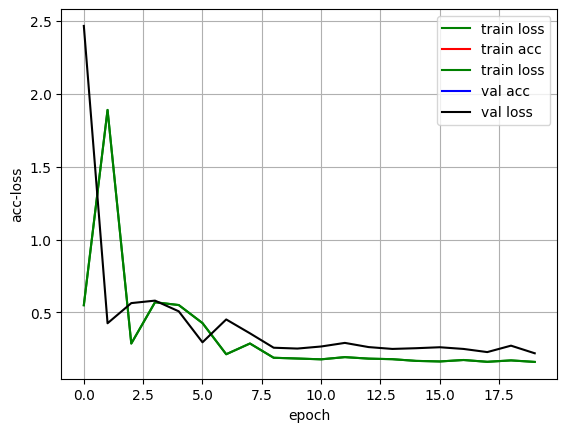

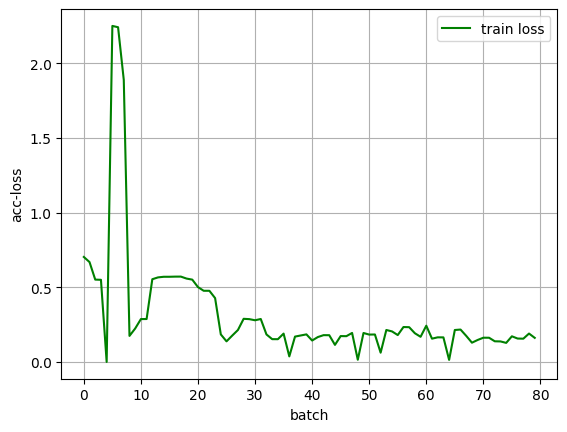

In [42]:
cnn_by_own(input_shape=INPUT_SIZE,num_class=2,epochs=20)
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

***XCEPTION NET***


In [43]:
def xception( num_class, epochs,savepath='./xception.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = Xception(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:131]:		#could be tuned to be 50, 100, or 131
        layer.trainable = False
    for layer in model_fine_tune.layers[131:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='xception')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_acc', patience=3, verbose=1, mode='auto')	#patience could be tuned by 2 and 3
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_acc',
        verbose=1,
        save_best_only=False,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[earlyStopping, saveBestModel, history],
    )

Epoch 1/20
4/4 [==============================] - ETA: 0s - loss: 0.4034 - accuracy: 0.8442WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 1: saving model to .\xception.h5
4/4 [==============================] - 43s 11s/step - loss: 0.4034 - accuracy: 0.8442 - val_loss: 0.4425 - val_accuracy: 0.9377
Epoch 2/20
4/4 [==============================] - ETA: 0s - loss: 0.2364 - accuracy: 0.9636WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 2: saving model to .\xception.h5
4/4 [==============================] - 38s 11s/step - loss: 0.2364 - accuracy: 0.9636 - val_loss: 0.4187 - val_accuracy: 0.9377
Epoch 3/20
4/4 [==============================] - ETA: 0s - loss: 0.2065 - accuracy: 0.9636WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 3: saving model to .\xception.h5
4/4 [==============================] - 35s 10s/step - loss: 0.2065 - accuracy: 0.9636 - val_loss: 0.3461 - val_accuracy: 0.9377
Epoch 4/20
4/4 [==============================] - ETA: 0s - loss: 0.1776 - accuracy: 0.9636WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 4: saving model to .\xception.h5
4/4 [==============================] - 35s 10s/step - loss: 0.1776 - accuracy: 0.9636 - val_loss: 0.2492 - val_accuracy: 0.9377
Epoch 5/20
4/4 [==============================] - ETA: 0s - loss: 0.1374 - accuracy: 0.9636WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 5: saving model to .\xception.h5
4/4 [==============================] - 36s 10s/step - loss: 0.1374 - accuracy: 0.9636 - val_loss: 0.1712 - val_accuracy: 0.9377
Epoch 6/20
4/4 [==============================] - ETA: 0s - loss: 0.1097 - accuracy: 0.9636WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 6: saving model to .\xception.h5
4/4 [==============================] - 34s 9s/step - loss: 0.1097 - accuracy: 0.9636 - val_loss: 0.1397 - val_accuracy: 0.9377
Epoch 7/20
4/4 [==============================] - ETA: 0s - loss: 0.0937 - accuracy: 0.9662WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 7: saving model to .\xception.h5
4/4 [==============================] - 34s 10s/step - loss: 0.0937 - accuracy: 0.9662 - val_loss: 0.1192 - val_accuracy: 0.9403
Epoch 8/20
4/4 [==============================] - ETA: 0s - loss: 0.0753 - accuracy: 0.9662WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 8: saving model to .\xception.h5
4/4 [==============================] - 33s 9s/step - loss: 0.0753 - accuracy: 0.9662 - val_loss: 0.1088 - val_accuracy: 0.9403
Epoch 9/20
4/4 [==============================] - ETA: 0s - loss: 0.0695 - accuracy: 0.9688WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 9: saving model to .\xception.h5
4/4 [==============================] - 35s 12s/step - loss: 0.0695 - accuracy: 0.9688 - val_loss: 0.1016 - val_accuracy: 0.9429
Epoch 10/20
4/4 [==============================] - ETA: 0s - loss: 0.0577 - accuracy: 0.9688WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 10: saving model to .\xception.h5
4/4 [==============================] - 36s 10s/step - loss: 0.0577 - accuracy: 0.9688 - val_loss: 0.1002 - val_accuracy: 0.9429
Epoch 11/20
4/4 [==============================] - ETA: 0s - loss: 0.0528 - accuracy: 0.9740WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 11: saving model to .\xception.h5
4/4 [==============================] - 34s 9s/step - loss: 0.0528 - accuracy: 0.9740 - val_loss: 0.1002 - val_accuracy: 0.9506
Epoch 12/20
4/4 [==============================] - ETA: 0s - loss: 0.0520 - accuracy: 0.9714WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 12: saving model to .\xception.h5
4/4 [==============================] - 38s 11s/step - loss: 0.0520 - accuracy: 0.9714 - val_loss: 0.0877 - val_accuracy: 0.9558
Epoch 13/20
4/4 [==============================] - ETA: 0s - loss: 0.0469 - accuracy: 0.9740WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 13: saving model to .\xception.h5
4/4 [==============================] - 39s 11s/step - loss: 0.0469 - accuracy: 0.9740 - val_loss: 0.0767 - val_accuracy: 0.9584
Epoch 14/20
4/4 [==============================] - ETA: 0s - loss: 0.0405 - accuracy: 0.9818WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 14: saving model to .\xception.h5
4/4 [==============================] - 33s 9s/step - loss: 0.0405 - accuracy: 0.9818 - val_loss: 0.0669 - val_accuracy: 0.9688
Epoch 15/20
4/4 [==============================] - ETA: 0s - loss: 0.0380 - accuracy: 0.9766WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 15: saving model to .\xception.h5
4/4 [==============================] - 33s 9s/step - loss: 0.0380 - accuracy: 0.9766 - val_loss: 0.0629 - val_accuracy: 0.9714
Epoch 16/20
4/4 [==============================] - ETA: 0s - loss: 0.0363 - accuracy: 0.9766WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 16: saving model to .\xception.h5
4/4 [==============================] - 34s 9s/step - loss: 0.0363 - accuracy: 0.9766 - val_loss: 0.0634 - val_accuracy: 0.9714
Epoch 17/20
4/4 [==============================] - ETA: 0s - loss: 0.0326 - accuracy: 0.9844WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 17: saving model to .\xception.h5
4/4 [==============================] - 33s 11s/step - loss: 0.0326 - accuracy: 0.9844 - val_loss: 0.0691 - val_accuracy: 0.9688
Epoch 18/20
4/4 [==============================] - ETA: 0s - loss: 0.0334 - accuracy: 0.9792WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 18: saving model to .\xception.h5
4/4 [==============================] - 34s 10s/step - loss: 0.0334 - accuracy: 0.9792 - val_loss: 0.0667 - val_accuracy: 0.9740
Epoch 19/20
4/4 [==============================] - ETA: 0s - loss: 0.0290 - accuracy: 0.9818WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 19: saving model to .\xception.h5
4/4 [==============================] - 34s 9s/step - loss: 0.0290 - accuracy: 0.9818 - val_loss: 0.0615 - val_accuracy: 0.9792
Epoch 20/20
4/4 [==============================] - ETA: 0s - loss: 0.0246 - accuracy: 0.9896WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 20: saving model to .\xception.h5
4/4 [==============================] - 36s 10s/step - loss: 0.0246 - accuracy: 0.9896 - val_loss: 0.0594 - val_accuracy: 0.9818


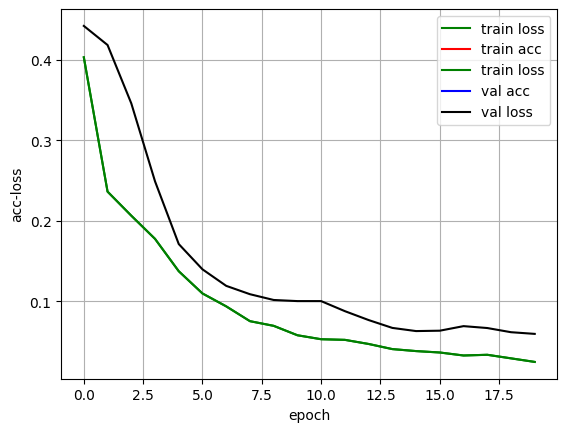

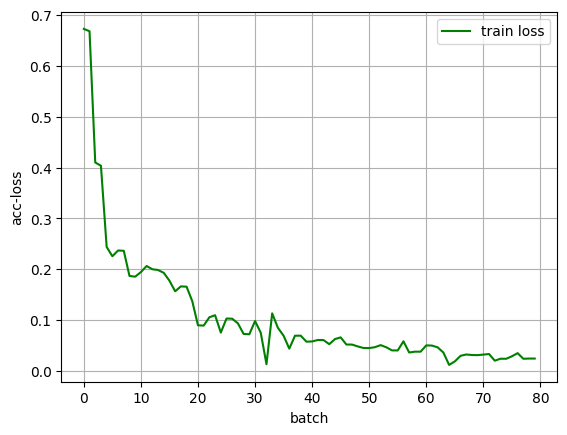

In [44]:
xception(num_class=2,epochs=20)
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

***VGG16***

In [45]:
def vgg16( num_class, epochs,savepath='./VGG16.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:15]:	#the number of frozen layers for transfer learning, have tuned from 5-18
        layer.trainable = False
    for layer in model_fine_tune.layers[15:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output) #GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='vgg')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])	#set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_acc', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_acc',
        verbose=1,
        save_best_only=False,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        #workers=2,
        callbacks=[earlyStopping, saveBestModel, history],
    )

Epoch 1/20
4/4 [==============================] - ETA: 0s - loss: 0.3369 - accuracy: 0.9247WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 1: saving model to .\VGG16.h5
4/4 [==============================] - 102s 27s/step - loss: 0.3369 - accuracy: 0.9247 - val_loss: 0.4420 - val_accuracy: 0.9377
Epoch 2/20
4/4 [==============================] - ETA: 0s - loss: 0.2431 - accuracy: 0.9532WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 2: saving model to .\VGG16.h5
4/4 [==============================] - 102s 27s/step - loss: 0.2431 - accuracy: 0.9532 - val_loss: 0.3308 - val_accuracy: 0.9377
Epoch 3/20
4/4 [==============================] - ETA: 0s - loss: 0.1930 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 3: saving model to .\VGG16.h5
4/4 [==============================] - 95s 26s/step - loss: 0.1930 - accuracy: 0.9636 - val_loss: 0.2496 - val_accuracy: 0.9377
Epoch 4/20
4/4 [==============================] - ETA: 0s - loss: 0.1575 - accuracy: 0.9636WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 4: saving model to .\VGG16.h5
4/4 [==============================] - 97s 26s/step - loss: 0.1575 - accuracy: 0.9636 - val_loss: 0.4256 - val_accuracy: 0.9377
Epoch 5/20
4/4 [==============================] - ETA: 0s - loss: 0.2117 - accuracy: 0.9636WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 5: saving model to .\VGG16.h5
4/4 [==============================] - 96s 26s/step - loss: 0.2117 - accuracy: 0.9636 - val_loss: 0.2246 - val_accuracy: 0.9377
Epoch 6/20
4/4 [==============================] - ETA: 0s - loss: 0.1417 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 6: saving model to .\VGG16.h5
4/4 [==============================] - 96s 26s/step - loss: 0.1417 - accuracy: 0.9636 - val_loss: 0.2473 - val_accuracy: 0.9377
Epoch 7/20
4/4 [==============================] - ETA: 0s - loss: 0.1388 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 7: saving model to .\VGG16.h5
4/4 [==============================] - 97s 26s/step - loss: 0.1388 - accuracy: 0.9636 - val_loss: 0.1369 - val_accuracy: 0.9377
Epoch 8/20
4/4 [==============================] - ETA: 0s - loss: 0.1192 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 8: saving model to .\VGG16.h5
4/4 [==============================] - 96s 32s/step - loss: 0.1192 - accuracy: 0.9636 - val_loss: 0.1310 - val_accuracy: 0.9377
Epoch 9/20
4/4 [==============================] - ETA: 0s - loss: 0.0831 - accuracy: 0.9636WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 9: saving model to .\VGG16.h5
4/4 [==============================] - 96s 26s/step - loss: 0.0831 - accuracy: 0.9636 - val_loss: 0.1101 - val_accuracy: 0.9377
Epoch 10/20
4/4 [==============================] - ETA: 0s - loss: 0.0607 - accuracy: 0.9636WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 10: saving model to .\VGG16.h5
4/4 [==============================] - 97s 27s/step - loss: 0.0607 - accuracy: 0.9636 - val_loss: 0.0939 - val_accuracy: 0.9377
Epoch 11/20
4/4 [==============================] - ETA: 0s - loss: 0.0359 - accuracy: 0.9636WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 11: saving model to .\VGG16.h5
4/4 [==============================] - 96s 26s/step - loss: 0.0359 - accuracy: 0.9636 - val_loss: 0.0774 - val_accuracy: 0.9377
Epoch 12/20
4/4 [==============================] - ETA: 0s - loss: 0.0309 - accuracy: 0.9636  WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 12: saving model to .\VGG16.h5
4/4 [==============================] - 97s 32s/step - loss: 0.0309 - accuracy: 0.9636 - val_loss: 0.0904 - val_accuracy: 0.9377
Epoch 13/20
4/4 [==============================] - ETA: 0s - loss: 0.0281 - accuracy: 0.9636  WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 13: saving model to .\VGG16.h5
4/4 [==============================] - 96s 32s/step - loss: 0.0281 - accuracy: 0.9636 - val_loss: 0.0813 - val_accuracy: 0.9377
Epoch 14/20
4/4 [==============================] - ETA: 0s - loss: 0.0275 - accuracy: 0.9662  WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 14: saving model to .\VGG16.h5
4/4 [==============================] - 95s 32s/step - loss: 0.0275 - accuracy: 0.9662 - val_loss: 0.0836 - val_accuracy: 0.9377
Epoch 15/20
4/4 [==============================] - ETA: 0s - loss: 0.0269 - accuracy: 0.9818WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 15: saving model to .\VGG16.h5
4/4 [==============================] - 96s 26s/step - loss: 0.0269 - accuracy: 0.9818 - val_loss: 0.1021 - val_accuracy: 0.9688
Epoch 16/20
4/4 [==============================] - ETA: 0s - loss: 0.0256 - accuracy: 0.9870 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 16: saving model to .\VGG16.h5
4/4 [==============================] - 95s 26s/step - loss: 0.0256 - accuracy: 0.9870 - val_loss: 0.0927 - val_accuracy: 0.9818
Epoch 17/20
4/4 [==============================] - ETA: 0s - loss: 0.0248 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 17: saving model to .\VGG16.h5
4/4 [==============================] - 95s 26s/step - loss: 0.0248 - accuracy: 1.0000 - val_loss: 0.0935 - val_accuracy: 0.9922
Epoch 18/20
4/4 [==============================] - ETA: 0s - loss: 0.0243 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 18: saving model to .\VGG16.h5
4/4 [==============================] - 96s 26s/step - loss: 0.0243 - accuracy: 1.0000 - val_loss: 0.1022 - val_accuracy: 0.9896
Epoch 19/20
4/4 [==============================] - ETA: 0s - loss: 0.0239 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 19: saving model to .\VGG16.h5
4/4 [==============================] - 96s 26s/step - loss: 0.0239 - accuracy: 1.0000 - val_loss: 0.1133 - val_accuracy: 0.9818
Epoch 20/20
4/4 [==============================] - ETA: 0s - loss: 0.0233 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 20: saving model to .\VGG16.h5
4/4 [==============================] - 95s 26s/step - loss: 0.0233 - accuracy: 1.0000 - val_loss: 0.1198 - val_accuracy: 0.9818


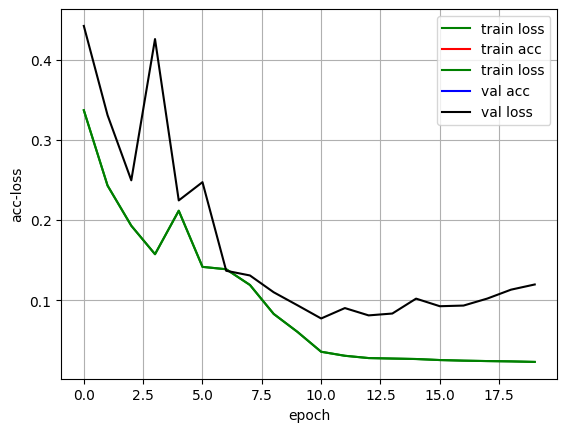

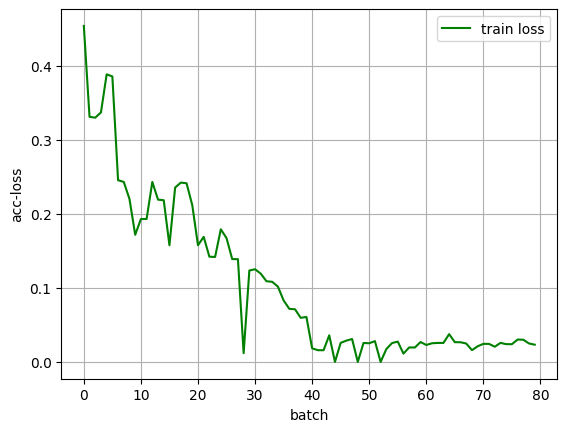

In [46]:
vgg16(num_class=2,epochs=20)	#tf36cnn
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

***VGG19***

In [47]:
def vgg19( num_class, epochs,savepath='./VGG19.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:19]:	#the number of frozen layers for transfer learning, have tuned from 5-18
        layer.trainable = False
    for layer in model_fine_tune.layers[19:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='vgg')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])	#set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_acc', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_acc',
        verbose=1,
        save_best_only=False,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        #workers=2,
        callbacks=[earlyStopping, saveBestModel, history],
    )

Epoch 1/20
4/4 [==============================] - ETA: 0s - loss: 0.7294 - accuracy: 0.6701 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 1: saving model to .\VGG19.h5
4/4 [==============================] - 120s 33s/step - loss: 0.7294 - accuracy: 0.6701 - val_loss: 0.4275 - val_accuracy: 0.9377
Epoch 2/20
4/4 [==============================] - ETA: 0s - loss: 0.2792 - accuracy: 0.9558 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 2: saving model to .\VGG19.h5
4/4 [==============================] - 125s 35s/step - loss: 0.2792 - accuracy: 0.9558 - val_loss: 0.4129 - val_accuracy: 0.9377
Epoch 3/20
4/4 [==============================] - ETA: 0s - loss: 0.2670 - accuracy: 0.9506 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 3: saving model to .\VGG19.h5
4/4 [==============================] - 124s 33s/step - loss: 0.2670 - accuracy: 0.9506 - val_loss: 0.3041 - val_accuracy: 0.9377
Epoch 4/20
4/4 [==============================] - ETA: 0s - loss: 0.2207 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 4: saving model to .\VGG19.h5
4/4 [==============================] - 117s 39s/step - loss: 0.2207 - accuracy: 0.9636 - val_loss: 0.2182 - val_accuracy: 0.9377
Epoch 5/20
4/4 [==============================] - ETA: 0s - loss: 0.2001 - accuracy: 0.9481 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 5: saving model to .\VGG19.h5
4/4 [==============================] - 118s 32s/step - loss: 0.2001 - accuracy: 0.9481 - val_loss: 0.3466 - val_accuracy: 0.9377
Epoch 6/20
4/4 [==============================] - ETA: 0s - loss: 0.2884 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 6: saving model to .\VGG19.h5
4/4 [==============================] - 117s 39s/step - loss: 0.2884 - accuracy: 0.9636 - val_loss: 0.4320 - val_accuracy: 0.9377
Epoch 7/20
4/4 [==============================] - ETA: 0s - loss: 0.2260 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 7: saving model to .\VGG19.h5
4/4 [==============================] - 117s 32s/step - loss: 0.2260 - accuracy: 0.9636 - val_loss: 0.2120 - val_accuracy: 0.9377
Epoch 8/20
4/4 [==============================] - ETA: 0s - loss: 0.1732 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 8: saving model to .\VGG19.h5
4/4 [==============================] - 117s 39s/step - loss: 0.1732 - accuracy: 0.9636 - val_loss: 0.1911 - val_accuracy: 0.9377
Epoch 9/20
4/4 [==============================] - ETA: 0s - loss: 0.1530 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 9: saving model to .\VGG19.h5
4/4 [==============================] - 117s 32s/step - loss: 0.1530 - accuracy: 0.9636 - val_loss: 0.1816 - val_accuracy: 0.9377
Epoch 10/20
4/4 [==============================] - ETA: 0s - loss: 0.1120 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 10: saving model to .\VGG19.h5
4/4 [==============================] - 117s 39s/step - loss: 0.1120 - accuracy: 0.9636 - val_loss: 0.1201 - val_accuracy: 0.9377
Epoch 11/20
4/4 [==============================] - ETA: 0s - loss: 0.0761 - accuracy: 0.9714 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 11: saving model to .\VGG19.h5
4/4 [==============================] - 117s 32s/step - loss: 0.0761 - accuracy: 0.9714 - val_loss: 0.1323 - val_accuracy: 0.9403
Epoch 12/20
4/4 [==============================] - ETA: 0s - loss: 0.0554 - accuracy: 0.9714 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 12: saving model to .\VGG19.h5
4/4 [==============================] - 117s 32s/step - loss: 0.0554 - accuracy: 0.9714 - val_loss: 0.0505 - val_accuracy: 0.9974
Epoch 13/20
4/4 [==============================] - ETA: 0s - loss: 0.0332 - accuracy: 0.9870 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 13: saving model to .\VGG19.h5
4/4 [==============================] - 116s 32s/step - loss: 0.0332 - accuracy: 0.9870 - val_loss: 0.0714 - val_accuracy: 0.9714
Epoch 14/20
4/4 [==============================] - ETA: 0s - loss: 0.0252 - accuracy: 0.9844  WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 14: saving model to .\VGG19.h5
4/4 [==============================] - 117s 39s/step - loss: 0.0252 - accuracy: 0.9844 - val_loss: 0.0443 - val_accuracy: 0.9922
Epoch 15/20
4/4 [==============================] - ETA: 0s - loss: 0.0889 - accuracy: 0.9740 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 15: saving model to .\VGG19.h5
4/4 [==============================] - 118s 33s/step - loss: 0.0889 - accuracy: 0.9740 - val_loss: 0.0940 - val_accuracy: 0.9662
Epoch 16/20
4/4 [==============================] - ETA: 0s - loss: 0.0391 - accuracy: 0.9870 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 16: saving model to .\VGG19.h5
4/4 [==============================] - 119s 33s/step - loss: 0.0391 - accuracy: 0.9870 - val_loss: 0.0213 - val_accuracy: 0.9974
Epoch 17/20
4/4 [==============================] - ETA: 0s - loss: 0.0126 - accuracy: 0.9948 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 17: saving model to .\VGG19.h5
4/4 [==============================] - 117s 32s/step - loss: 0.0126 - accuracy: 0.9948 - val_loss: 0.1153 - val_accuracy: 0.9636
Epoch 18/20
4/4 [==============================] - ETA: 0s - loss: 0.0390 - accuracy: 0.9818 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 18: saving model to .\VGG19.h5
4/4 [==============================] - 117s 32s/step - loss: 0.0390 - accuracy: 0.9818 - val_loss: 0.0203 - val_accuracy: 0.9974
Epoch 19/20
4/4 [==============================] - ETA: 0s - loss: 0.0206 - accuracy: 0.9974 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 19: saving model to .\VGG19.h5
4/4 [==============================] - 117s 32s/step - loss: 0.0206 - accuracy: 0.9974 - val_loss: 0.0184 - val_accuracy: 0.9974
Epoch 20/20
4/4 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000  WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 20: saving model to .\VGG19.h5
4/4 [==============================] - 117s 39s/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0487 - val_accuracy: 0.9818


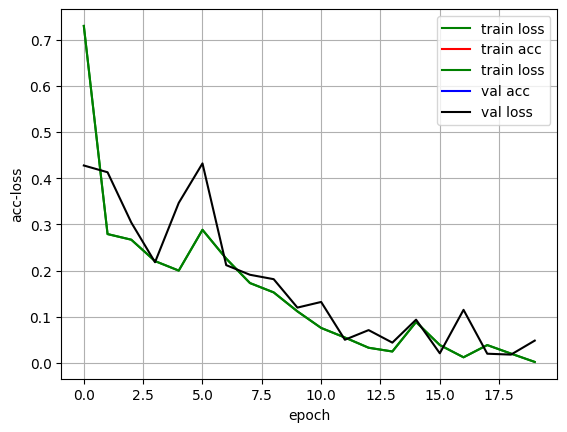

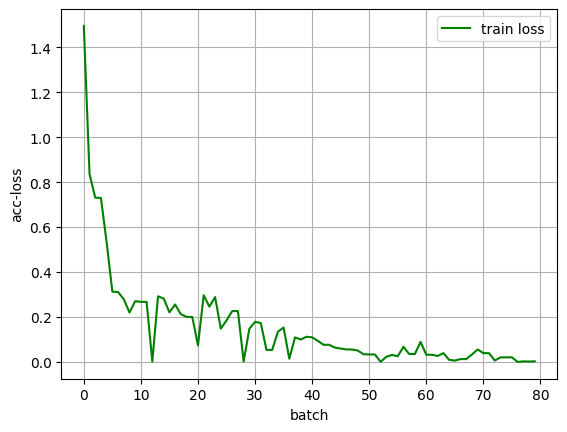

In [48]:
vgg19(num_class=2,epochs=20)	#binary classificaiton
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

ResNet

In [49]:
def resnet( num_class, epochs,savepath='./resnet.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:120]:	#the number of frozen layers for transfer learning, have tuned from 50-150
        layer.trainable = False
    for layer in model_fine_tune.layers[120:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_acc', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_acc',
        verbose=1,
        save_best_only=False,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[earlyStopping, saveBestModel, history],
    )

Epoch 1/20
4/4 [==============================] - ETA: 0s - loss: 0.4079 - accuracy: 0.8727WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 1: saving model to .\resnet.h5
4/4 [==============================] - 53s 11s/step - loss: 0.4079 - accuracy: 0.8727 - val_loss: 0.9407 - val_accuracy: 0.9377
Epoch 2/20
4/4 [==============================] - ETA: 0s - loss: 0.2175 - accuracy: 0.9636WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 2: saving model to .\resnet.h5
4/4 [==============================] - 38s 10s/step - loss: 0.2175 - accuracy: 0.9636 - val_loss: 1.4811 - val_accuracy: 0.9377
Epoch 3/20
4/4 [==============================] - ETA: 0s - loss: 0.2593 - accuracy: 0.9636WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 3: saving model to .\resnet.h5
4/4 [==============================] - 39s 10s/step - loss: 0.2593 - accuracy: 0.9636 - val_loss: 3.4856 - val_accuracy: 0.9377
Epoch 4/20
4/4 [==============================] - ETA: 0s - loss: 0.1357 - accuracy: 0.9636WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 4: saving model to .\resnet.h5
4/4 [==============================] - 38s 13s/step - loss: 0.1357 - accuracy: 0.9636 - val_loss: 11.2271 - val_accuracy: 0.9377
Epoch 5/20
4/4 [==============================] - ETA: 0s - loss: 0.1093 - accuracy: 0.9636WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 5: saving model to .\resnet.h5
4/4 [==============================] - 39s 10s/step - loss: 0.1093 - accuracy: 0.9636 - val_loss: 53.6821 - val_accuracy: 0.9377
Epoch 6/20
4/4 [==============================] - ETA: 0s - loss: 0.0661 - accuracy: 0.9636WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 6: saving model to .\resnet.h5
4/4 [==============================] - 39s 10s/step - loss: 0.0661 - accuracy: 0.9636 - val_loss: 132.8210 - val_accuracy: 0.9377
Epoch 7/20
4/4 [==============================] - ETA: 0s - loss: 0.0770 - accuracy: 0.9688 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 7: saving model to .\resnet.h5
4/4 [==============================] - 38s 13s/step - loss: 0.0770 - accuracy: 0.9688 - val_loss: 180.7785 - val_accuracy: 0.9377
Epoch 8/20
4/4 [==============================] - ETA: 0s - loss: 0.0314 - accuracy: 0.9870 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 8: saving model to .\resnet.h5
4/4 [==============================] - 39s 13s/step - loss: 0.0314 - accuracy: 0.9870 - val_loss: 328.1012 - val_accuracy: 0.9377
Epoch 9/20
4/4 [==============================] - ETA: 0s - loss: 0.0222 - accuracy: 0.9974WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 9: saving model to .\resnet.h5
4/4 [==============================] - 38s 10s/step - loss: 0.0222 - accuracy: 0.9974 - val_loss: 398.4352 - val_accuracy: 0.9377
Epoch 10/20
4/4 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 10: saving model to .\resnet.h5
4/4 [==============================] - 39s 10s/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 558.6033 - val_accuracy: 0.9377
Epoch 11/20
4/4 [==============================] - ETA: 0s - loss: 0.0090 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 11: saving model to .\resnet.h5
4/4 [==============================] - 38s 10s/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 474.7280 - val_accuracy: 0.9377
Epoch 12/20
4/4 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 12: saving model to .\resnet.h5
4/4 [==============================] - 38s 10s/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 424.6740 - val_accuracy: 0.9377
Epoch 13/20
4/4 [==============================] - ETA: 0s - loss: 0.0038 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 13: saving model to .\resnet.h5
4/4 [==============================] - 38s 13s/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 378.8427 - val_accuracy: 0.9377
Epoch 14/20
4/4 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 14: saving model to .\resnet.h5
4/4 [==============================] - 38s 13s/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 321.0155 - val_accuracy: 0.9377
Epoch 15/20
4/4 [==============================] - ETA: 0s - loss: 5.0677e-04 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 15: saving model to .\resnet.h5
4/4 [==============================] - 38s 10s/step - loss: 5.0677e-04 - accuracy: 1.0000 - val_loss: 253.4718 - val_accuracy: 0.9377
Epoch 16/20
4/4 [==============================] - ETA: 0s - loss: 8.2392e-04 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 16: saving model to .\resnet.h5
4/4 [==============================] - 38s 10s/step - loss: 8.2392e-04 - accuracy: 1.0000 - val_loss: 194.9545 - val_accuracy: 0.9377
Epoch 17/20
4/4 [==============================] - ETA: 0s - loss: 3.8938e-04 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 17: saving model to .\resnet.h5
4/4 [==============================] - 39s 13s/step - loss: 3.8938e-04 - accuracy: 1.0000 - val_loss: 149.9322 - val_accuracy: 0.9377
Epoch 18/20
4/4 [==============================] - ETA: 0s - loss: 3.2701e-04 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 18: saving model to .\resnet.h5
4/4 [==============================] - 38s 10s/step - loss: 3.2701e-04 - accuracy: 1.0000 - val_loss: 117.6963 - val_accuracy: 0.9377
Epoch 19/20
4/4 [==============================] - ETA: 0s - loss: 1.9545e-04 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 19: saving model to .\resnet.h5
4/4 [==============================] - 38s 10s/step - loss: 1.9545e-04 - accuracy: 1.0000 - val_loss: 93.0519 - val_accuracy: 0.9377
Epoch 20/20
4/4 [==============================] - ETA: 0s - loss: 3.7306e-04 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 20: saving model to .\resnet.h5
4/4 [==============================] - 39s 10s/step - loss: 3.7306e-04 - accuracy: 1.0000 - val_loss: 75.9523 - val_accuracy: 0.9377


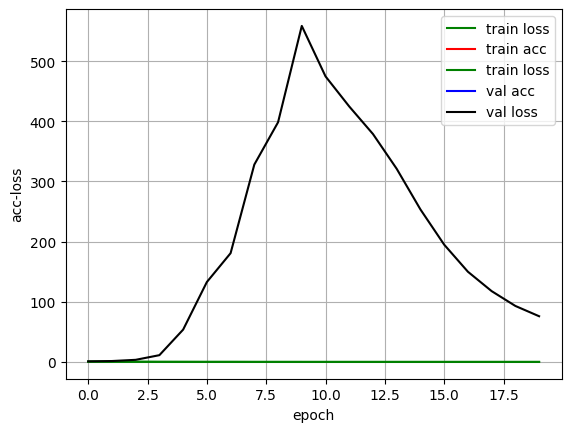

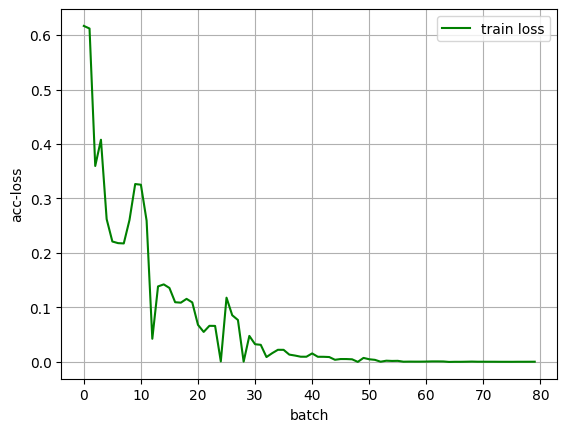

In [50]:
resnet(num_class=2,epochs=20)	#binary classificaiton
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

***Inception***

In [51]:
def inception( num_class, epochs,savepath='./inception.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:35]:	#the number of frozen layers for transfer learning, have tuned from 50-150
        layer.trainable = False
    for layer in model_fine_tune.layers[35:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_acc', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_acc',
        verbose=1,
        save_best_only=False,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[earlyStopping, saveBestModel, history],
    )

Epoch 1/20
4/4 [==============================] - ETA: 0s - loss: 0.3979 - accuracy: 0.8234WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 1: saving model to .\inception.h5
4/4 [==============================] - 50s 10s/step - loss: 0.3979 - accuracy: 0.8234 - val_loss: 3.3804 - val_accuracy: 0.9377
Epoch 2/20
4/4 [==============================] - ETA: 0s - loss: 0.0347 - accuracy: 0.9844WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 2: saving model to .\inception.h5
4/4 [==============================] - 34s 9s/step - loss: 0.0347 - accuracy: 0.9844 - val_loss: 2.7182 - val_accuracy: 0.9377
Epoch 3/20
4/4 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 3: saving model to .\inception.h5
4/4 [==============================] - 33s 11s/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 1.8181 - val_accuracy: 0.9377
Epoch 4/20
4/4 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 4: saving model to .\inception.h5
4/4 [==============================] - 33s 8s/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 1.0088 - val_accuracy: 0.9377
Epoch 5/20
4/4 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 5: saving model to .\inception.h5
4/4 [==============================] - 33s 11s/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.5210 - val_accuracy: 0.9377
Epoch 6/20
4/4 [==============================] - ETA: 0s - loss: 2.4551e-04 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 6: saving model to .\inception.h5
4/4 [==============================] - 32s 8s/step - loss: 2.4551e-04 - accuracy: 1.0000 - val_loss: 0.1622 - val_accuracy: 0.9481
Epoch 7/20
4/4 [==============================] - ETA: 0s - loss: 1.6662e-04 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 7: saving model to .\inception.h5
4/4 [==============================] - 33s 8s/step - loss: 1.6662e-04 - accuracy: 1.0000 - val_loss: 0.0649 - val_accuracy: 0.9740
Epoch 8/20
4/4 [==============================] - ETA: 0s - loss: 1.1748e-04 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 8: saving model to .\inception.h5
4/4 [==============================] - 32s 8s/step - loss: 1.1748e-04 - accuracy: 1.0000 - val_loss: 0.3472 - val_accuracy: 0.8494
Epoch 9/20
4/4 [==============================] - ETA: 0s - loss: 5.9725e-05 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 9: saving model to .\inception.h5
4/4 [==============================] - 33s 8s/step - loss: 5.9725e-05 - accuracy: 1.0000 - val_loss: 0.9428 - val_accuracy: 0.6416
Epoch 10/20
4/4 [==============================] - ETA: 0s - loss: 1.5173e-04 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 10: saving model to .\inception.h5
4/4 [==============================] - 33s 9s/step - loss: 1.5173e-04 - accuracy: 1.0000 - val_loss: 1.7031 - val_accuracy: 0.4649
Epoch 11/20
4/4 [==============================] - ETA: 0s - loss: 5.6648e-05 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 11: saving model to .\inception.h5
4/4 [==============================] - 34s 9s/step - loss: 5.6648e-05 - accuracy: 1.0000 - val_loss: 2.4418 - val_accuracy: 0.3610
Epoch 12/20
4/4 [==============================] - ETA: 0s - loss: 5.4147e-05 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 12: saving model to .\inception.h5
4/4 [==============================] - 36s 10s/step - loss: 5.4147e-05 - accuracy: 1.0000 - val_loss: 2.9759 - val_accuracy: 0.2675
Epoch 13/20
4/4 [==============================] - ETA: 0s - loss: 1.0378e-05 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 13: saving model to .\inception.h5
4/4 [==============================] - 38s 13s/step - loss: 1.0378e-05 - accuracy: 1.0000 - val_loss: 3.4137 - val_accuracy: 0.2078
Epoch 14/20
4/4 [==============================] - ETA: 0s - loss: 3.3693e-05 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 14: saving model to .\inception.h5
4/4 [==============================] - 35s 9s/step - loss: 3.3693e-05 - accuracy: 1.0000 - val_loss: 3.6100 - val_accuracy: 0.1974
Epoch 15/20
4/4 [==============================] - ETA: 0s - loss: 2.3699e-05 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 15: saving model to .\inception.h5
4/4 [==============================] - 33s 8s/step - loss: 2.3699e-05 - accuracy: 1.0000 - val_loss: 3.6498 - val_accuracy: 0.2052
Epoch 16/20
4/4 [==============================] - ETA: 0s - loss: 1.4206e-04 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 16: saving model to .\inception.h5
4/4 [==============================] - 32s 8s/step - loss: 1.4206e-04 - accuracy: 1.0000 - val_loss: 3.6484 - val_accuracy: 0.2104
Epoch 17/20
4/4 [==============================] - ETA: 0s - loss: 8.8927e-06 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 17: saving model to .\inception.h5
4/4 [==============================] - 33s 8s/step - loss: 8.8927e-06 - accuracy: 1.0000 - val_loss: 3.5784 - val_accuracy: 0.2260
Epoch 18/20
4/4 [==============================] - ETA: 0s - loss: 4.0354e-06 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 18: saving model to .\inception.h5
4/4 [==============================] - 33s 9s/step - loss: 4.0354e-06 - accuracy: 1.0000 - val_loss: 3.4794 - val_accuracy: 0.2649
Epoch 19/20
4/4 [==============================] - ETA: 0s - loss: 3.1008e-05 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 19: saving model to .\inception.h5
4/4 [==============================] - 33s 8s/step - loss: 3.1008e-05 - accuracy: 1.0000 - val_loss: 3.2844 - val_accuracy: 0.2909
Epoch 20/20
4/4 [==============================] - ETA: 0s - loss: 1.2865e-05 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 20: saving model to .\inception.h5
4/4 [==============================] - 36s 9s/step - loss: 1.2865e-05 - accuracy: 1.0000 - val_loss: 3.0390 - val_accuracy: 0.3221


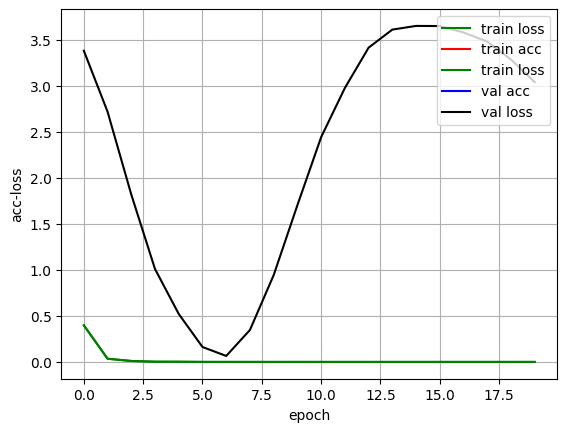

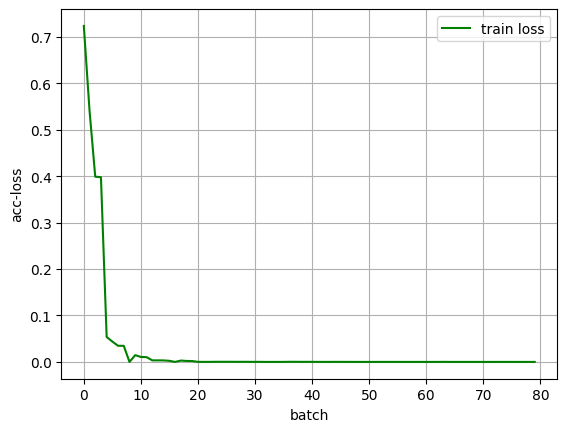

In [52]:
inception(num_class=2,epochs=20)	#binary classificaiton
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

***InceptionResnet***

In [53]:
def inceptionresnet( num_class, epochs,savepath='./inceptionresnet.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:500]:	#the number of frozen layers for transfer learning, have tuned from 400-550
        layer.trainable = False
    for layer in model_fine_tune.layers[500:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_acc', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_acc',
        verbose=1,
        save_best_only=False,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[earlyStopping, saveBestModel, history],
    )

Epoch 1/20
4/4 [==============================] - ETA: 0s - loss: 0.2556 - accuracy: 0.9273   WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 1: saving model to .\inceptionresnet.h5
4/4 [==============================] - 83s 22s/step - loss: 0.2556 - accuracy: 0.9273 - val_loss: 0.5743 - val_accuracy: 0.9377
Epoch 2/20
4/4 [==============================] - ETA: 0s - loss: 0.0088 - accuracy: 0.9974 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 2: saving model to .\inceptionresnet.h5
4/4 [==============================] - 61s 16s/step - loss: 0.0088 - accuracy: 0.9974 - val_loss: 0.7973 - val_accuracy: 0.9429
Epoch 3/20
4/4 [==============================] - ETA: 0s - loss: 0.0252 - accuracy: 0.9922 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 3: saving model to .\inceptionresnet.h5
4/4 [==============================] - 60s 16s/step - loss: 0.0252 - accuracy: 0.9922 - val_loss: 3.0823 - val_accuracy: 0.9377
Epoch 4/20
4/4 [==============================] - ETA: 0s - loss: 0.0925 - accuracy: 0.9896WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 4: saving model to .\inceptionresnet.h5
4/4 [==============================] - 61s 16s/step - loss: 0.0925 - accuracy: 0.9896 - val_loss: 2.1996 - val_accuracy: 0.9299
Epoch 5/20
4/4 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000  WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 5: saving model to .\inceptionresnet.h5
4/4 [==============================] - 60s 20s/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.6982 - val_accuracy: 0.9714
Epoch 6/20
4/4 [==============================] - ETA: 0s - loss: 4.9133e-04 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 6: saving model to .\inceptionresnet.h5
4/4 [==============================] - 61s 16s/step - loss: 4.9133e-04 - accuracy: 1.0000 - val_loss: 0.0103 - val_accuracy: 0.9974
Epoch 7/20
4/4 [==============================] - ETA: 0s - loss: 2.5058e-04 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 7: saving model to .\inceptionresnet.h5
4/4 [==============================] - 66s 18s/step - loss: 2.5058e-04 - accuracy: 1.0000 - val_loss: 0.3582 - val_accuracy: 0.9870
Epoch 8/20
4/4 [==============================] - ETA: 0s - loss: 2.6843e-05 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 8: saving model to .\inceptionresnet.h5
4/4 [==============================] - 61s 20s/step - loss: 2.6843e-05 - accuracy: 1.0000 - val_loss: 2.1898 - val_accuracy: 0.9688
Epoch 9/20
4/4 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 0.9974    WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 9: saving model to .\inceptionresnet.h5
4/4 [==============================] - 61s 16s/step - loss: 0.0025 - accuracy: 0.9974 - val_loss: 2.9749 - val_accuracy: 0.9688
Epoch 10/20
4/4 [==============================] - ETA: 0s - loss: 3.3728e-05 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 10: saving model to .\inceptionresnet.h5
4/4 [==============================] - 60s 16s/step - loss: 3.3728e-05 - accuracy: 1.0000 - val_loss: 1.6017 - val_accuracy: 0.9688
Epoch 11/20
4/4 [==============================] - ETA: 0s - loss: 5.6258e-05 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 11: saving model to .\inceptionresnet.h5
4/4 [==============================] - 61s 17s/step - loss: 5.6258e-05 - accuracy: 1.0000 - val_loss: 0.7205 - val_accuracy: 0.9377
Epoch 12/20
4/4 [==============================] - ETA: 0s - loss: 9.4249e-05 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 12: saving model to .\inceptionresnet.h5
4/4 [==============================] - 60s 16s/step - loss: 9.4249e-05 - accuracy: 1.0000 - val_loss: 5.8308 - val_accuracy: 0.8364
Epoch 13/20
4/4 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000   WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 13: saving model to .\inceptionresnet.h5
4/4 [==============================] - 59s 16s/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 50.2756 - val_accuracy: 0.9377
Epoch 14/20
4/4 [==============================] - ETA: 0s - loss: 0.0049 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 14: saving model to .\inceptionresnet.h5
4/4 [==============================] - 60s 16s/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 84.4493 - val_accuracy: 0.9377
Epoch 15/20
4/4 [==============================] - ETA: 0s - loss: 2.5592e-04 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 15: saving model to .\inceptionresnet.h5
4/4 [==============================] - 60s 20s/step - loss: 2.5592e-04 - accuracy: 1.0000 - val_loss: 57.9998 - val_accuracy: 0.9377
Epoch 16/20
4/4 [==============================] - ETA: 0s - loss: 4.2369e-06 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 16: saving model to .\inceptionresnet.h5
4/4 [==============================] - 60s 16s/step - loss: 4.2369e-06 - accuracy: 1.0000 - val_loss: 38.4836 - val_accuracy: 0.9377
Epoch 17/20
4/4 [==============================] - ETA: 0s - loss: 1.5413e-05 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 17: saving model to .\inceptionresnet.h5
4/4 [==============================] - 60s 16s/step - loss: 1.5413e-05 - accuracy: 1.0000 - val_loss: 25.5456 - val_accuracy: 0.9377
Epoch 18/20
4/4 [==============================] - ETA: 0s - loss: 1.3057e-05 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 18: saving model to .\inceptionresnet.h5
4/4 [==============================] - 60s 16s/step - loss: 1.3057e-05 - accuracy: 1.0000 - val_loss: 16.1533 - val_accuracy: 0.9377
Epoch 19/20
4/4 [==============================] - ETA: 0s - loss: 2.6465e-04 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 19: saving model to .\inceptionresnet.h5
4/4 [==============================] - 59s 16s/step - loss: 2.6465e-04 - accuracy: 1.0000 - val_loss: 10.7162 - val_accuracy: 0.9403
Epoch 20/20
4/4 [==============================] - ETA: 0s - loss: 1.9595e-05 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 20: saving model to .\inceptionresnet.h5
4/4 [==============================] - 61s 16s/step - loss: 1.9595e-05 - accuracy: 1.0000 - val_loss: 5.9076 - val_accuracy: 0.9351


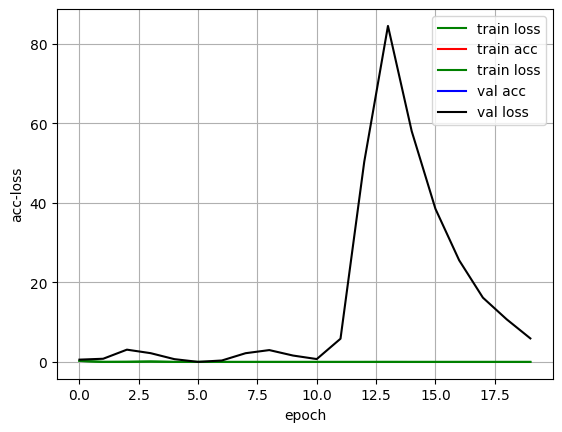

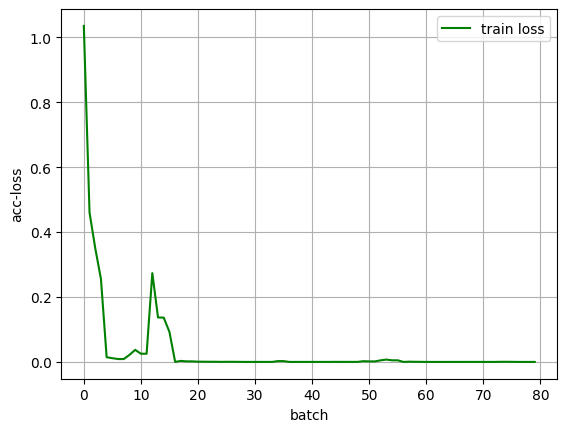

In [54]:
inceptionresnet(num_class=2,epochs=20)	# 5-class classificaiton
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()